## Table information

| column        | feature       |
| ------------- | ------------- |
| 1             | Area (A)      |
| 2             | Perimeter (P) |
| 3             | Compactness (C) = 4πA/P^2 |
| 4             | Length of kernel |
| 5             | Width of kernel |
| 6             | Asymmetry coefficient |
| 7             | Length of the kernel groove |
| 8             | Numerical class label |

## 1 Load and Visualizing the classes in the data
Read the dataset into Pandas. Add the appropriate label names to the columns, <br>
as per Table . Note that the data is tab delimitered.

### Problem a
Visualizing multidimensional data like this is a challenge. Visualizations <br>
seldom work in more than two dimensions. One way to systematically visualize <br>
the data is by projecting it to the constituent dimensions. <br>
Plot a scatter plot between each pair of features, coloring the points by <br>
the class label. Can we find structure? Can some pair of features tell all point <br>
reliably tell all or some classes apart? Include one interesting plot in your report <br>
and explain why you think it is interesting. <br>

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

columns = ['Area (A)', 'Perimeter (P)', 'Compactness (C)', 'Length of Kernel', 'Width of Kernel', 'Asymmetry Coefficient', 'Length of Kernel Groove', 'Class']
seed_df = pd.read_table('seeds.tsv', sep='\t')
seed_df.columns = columns

# Initially we had an idea of checking which pairs had the highest / lowest correlation but this didnt produce any satisfying results.
# We then decided to plot all possible pairs of features in an interactive window and just optically asses if the clusters seemed good enough to reliably classify the data.

# Divide the data into 3 classes
seed_df_class_1 = seed_df[seed_df['Class'] == 1]
seed_df_class_2 = seed_df[seed_df['Class'] == 2]
seed_df_class_3 = seed_df[seed_df['Class'] == 3]

# Plot all possible pairs of features, we noticed that Length of Kernel groove - length of kernel was a good pair to separate the classes
def select_plot(label,paired):
    plt.scatter(seed_df_class_1[label], seed_df_class_1[paired], color='red')
    plt.scatter(seed_df_class_2[label], seed_df_class_2[paired], color='blue')
    plt.scatter(seed_df_class_3[label], seed_df_class_3[paired], color='green')
    plt.xlabel(label)
    plt.ylabel(paired)
    plt.title(label + ' - ' + paired)
    plt.show()

interact(select_plot, label=columns, paired=columns)

interactive(children=(Dropdown(description='label', options=('Area (A)', 'Perimeter (P)', 'Compactness (C)', '…

<function __main__.select_plot(label, paired)>

### Problem b
Another way to obtain more feasible visualizations is through dimension- <br>
ality reduction. Apply Gaussian random projection to project the data to two <br>
dimensions. Plot a scatter plot and include the plot in your report. What does <br>
the data look like? <br>
Note that due to randomness, the results may vary, so you may want to try <br>
to do this a couple of times

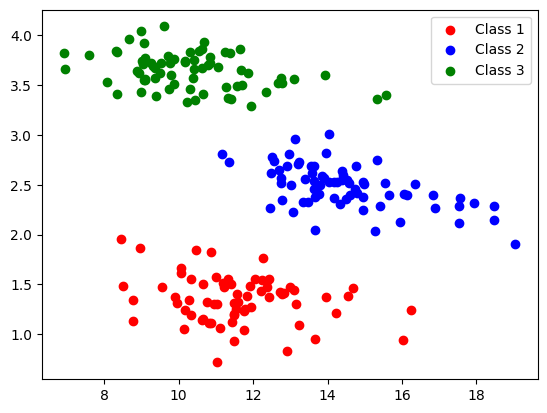

In [33]:
from sklearn.random_projection import GaussianRandomProjection

# Use gaussian random projection to reduce the dimensionality of the data into 2 dimensions
RANDOM_STATE_GRP = 38 # We noticed this random state gave the best separation of the classes

projection = GaussianRandomProjection(n_components=2, random_state=RANDOM_STATE_GRP)
seed_df_reduced = projection.fit_transform(seed_df)

# Plot the reduced data
plt.scatter(seed_df_reduced[seed_df['Class'] == 1][:, 0], seed_df_reduced[seed_df['Class'] == 1][:, 1], color='red')
plt.scatter(seed_df_reduced[seed_df['Class'] == 2][:, 0], seed_df_reduced[seed_df['Class'] == 2][:, 1], color='blue')
plt.scatter(seed_df_reduced[seed_df['Class'] == 3][:, 0], seed_df_reduced[seed_df['Class'] == 3][:, 1], color='green')
# legend for the plot
plt.legend(['Class 1', 'Class 2', 'Class 3'])
plt.show()

### Problem c
Another principled way to obtain an interesting projection to fewer dimen- <br>
sions is by applying UMAP, or Uniform Manifold Approximation and Projection <br>
for Dimensional Reduction [2] which projects the data on a (hypothesized) Rie- <br>
mannian manifold. Use the umap-learn package to project the data into two <br>
dimensions, plot a scatter plot, and include the plot in your report.

c:\Users\norlandw\Desktop\DIT-407-Data-Science-and-AI\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


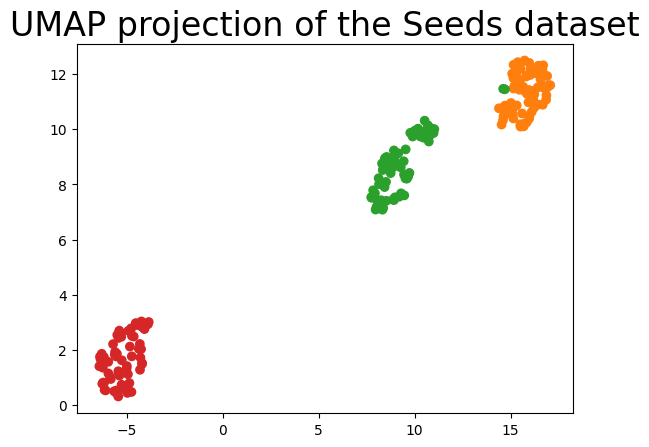

In [34]:
from sklearn.preprocessing import StandardScaler
import umap

RANDOM_STATE_UMAP = 1

reducer = umap.UMAP(random_state=RANDOM_STATE_UMAP) 
scaled_seed_data = StandardScaler().fit_transform(seed_df)
embedding = reducer.fit_transform(scaled_seed_data)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[plt.cm.tab10(i) for i in seed_df['Class']]
)
plt.title('UMAP projection of the Seeds dataset', fontsize=24)
plt.show()

### Problem d
Based on your observations in (a)–(c), does the data look linearly separa-
ble? Why / why not? What implications does this have for clustering?

**Answer:** <br>
Yes, depending on the random state chosen this is very much possible. <br>
In the pairwise scatter plot i judge you could linearly separate them just using those two features but the result wouldnt be perfect. <br>
In the example we picked in our gaussian projection you could (theoretically) separate the clusters using two horizontal lines with very good results. <br>
In the UMAP it pretty much looks like you could fit a regression line and get very good results just using that single line. <br>
Since the data is lineraly separable in two dimension, clustering should be easy since we then can make use of all dimensions to differentiate. <br>

## 2 Unsupervised Learning: Determining the appropriate number of clusters
You ought use exclude the class column for use in this question. This <br>
allows us to explore the data as if this was an unsupervised problem (i.e. assume <br>
we didn’t have any class labels).


### Problem a
As the features have different units and ranges of values, you should nor- <br>
malize the dataset appropriately. Remove the column representing the class <br>
label before you apply normalisation, as we are to treat this as an unsupervised <br>
problem (also, we do not want to normalise the class labels of course!). Describe <br>
what you did in your report.

In [35]:
from sklearn.preprocessing import MinMaxScaler

# use 0-1 scale for the data since this is the standard
scaler = MinMaxScaler((0,1))
seed_df_wo_class = seed_df.drop('Class', axis=1) # Drop the class column
seed_df_scaled = pd.DataFrame(scaler.fit_transform(seed_df_wo_class), columns=seed_df_wo_class.columns) # Normalize the data

### Problem b
Iterate over different values k = 1, 2, . . ., and apply k-means clustering on <br>
the data. For each value of k, compute the inertia, that is, the squared distance <br>
from each point to its nearest cluster center: <br>

Plot the inertia as a function of k. Eyeballing the plot, what would be an <br>
appropriate number of clusters? Justify your answer and include the plot in <br>
your report.

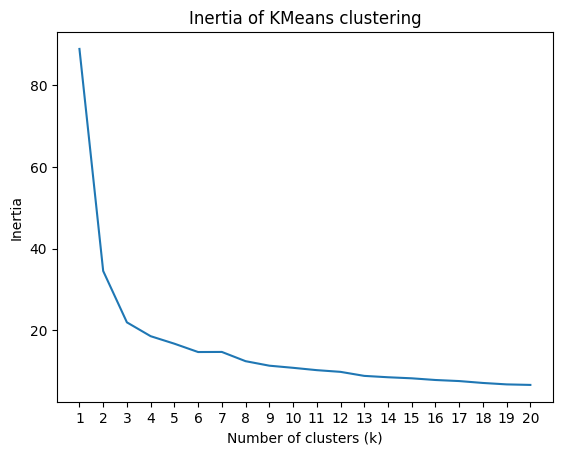

In [36]:
from sklearn.cluster import KMeans

RANDOM_STATE_KM = 1

def k_mean_clustering_inertia(k):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE_KM)
    kmeans.fit(seed_df_scaled)
    return kmeans.inertia_

k_range = range(1, 21)
inertias = [k_mean_clustering_inertia(k) for k in k_range]
plt.plot(k_range, inertias)
plt.xticks(k_range)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans clustering')
plt.show()

# We would argue that 3 is an appropriate number of clusters since there are three classes and the inertia does not seem to 
# decrease significantly after 3 clusters, as we can see in the plot.

## 3 Evaluating clustering
Apply k-means clustering to the data, but choose k to match the number of <br>
underlying species of wheat. It would seem like a reasonable assumption that<br>
there should be an equal number of clusters to the number of interesting classes<br>
in the data.<br>
Compute the Rand index of the clustering you obtain. The Rand index<br>
looks at each pair of points, and reports the fraction of points that are either in<br>
the same cluster in both clusterings, or in different clusters in both clusterings.<br>
That is, suppose ci is the cluster label of point i in one clustering and c′ i in another.<br>

Compute the Rand index between the clustering you obtained using k-means<br>
and the assumed correct clustering based on class labels.<br>
Furthermore, compute the accuracy of your clustering: the fraction of points<br>
that have been assigned to the correct class. As clustering is unsupervised, we<br>
do not have cluster identities as such; you may thus find the correct permutation<br>
of cluster labels, such that it best matches the class labels. That is, for each of<br>
the clusters obtained using using k-means, which label do you think should be<br>
attached to it?<br>

**Explanation:** Suppose we have k classes and k clusters. Let us denote [k] =<br>
{1, . . . , k}, and suppose c1, c2, . . . , cn ∈ [k] are the cluster labels (output of the<br>
clustering algorithm) and y1, y2, . . . , yk ∈ [k] are the correct class labels. We<br>
are looking for a permutation π : [k] → [k] that reorders the cluster labels such<br>
that the reordered cluster labels best match the correct class labels; that is, we<br>
define accuracy to be<br>


In [37]:
from sklearn.metrics import rand_score, accuracy_score

#apply kmeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE_KM) \
        .fit(seed_df_scaled)

predicted_labels = kmeans.labels_

label_mapping = {0: 2, 1: 3, 2: 1} # We assume that the labels from the kmeans are in the same order as the data. Since this produced a good accuracy we did not try them all.
for i in range(len(predicted_labels)): # To obtain the same labels as the true labels we need to map the predicted labels to the true labels
   predicted_labels[i] = label_mapping[predicted_labels[i]] 

true_labels = seed_df['Class'].tolist() # Get the true labels and reverse them to match the predicted labels

rand_index = rand_score(true_labels, kmeans.labels_)
kmeans_accuracy = accuracy_score(true_labels, kmeans.labels_)
print('Rand index:', rand_index)
print('Accuracy:', kmeans_accuracy) 

Rand index: 0.8639584100110416
Accuracy: 0.8851674641148325


## Problem 4 Supervised Learning: K-nearest neighbour
For this question, we will use the class labels of the original dataset and instead <br>
treat this as a supervised learning problem.<br>
Split the dataset into a training (80% of the data) and test set (20% of the<br>
data). Then, run the KNeightboursClassifier from sklearn on the data.<br>
You will notice that it takes a parameter n neighbours.<br>


### Problem a, b, c, d
How would you decide what value you should set n neighbours to? Explain <br>
your approach in your own words, max 3-5 sentences, clear and concise,<br>
don’t write more then you need<br>

Implement your approach from (a) and state your chosen value. Include<br>
the code, and a graph justifying your choice of value for n neighbours.<br>

For your chosen value, what is the accuracy on the test set? <br>

What would happen to your results if you repeated the above a-c on<br>
a different split into train-test? Explain your in your own words, max 3-5<br>
sentences, clear and concise, don’t write more then you need.

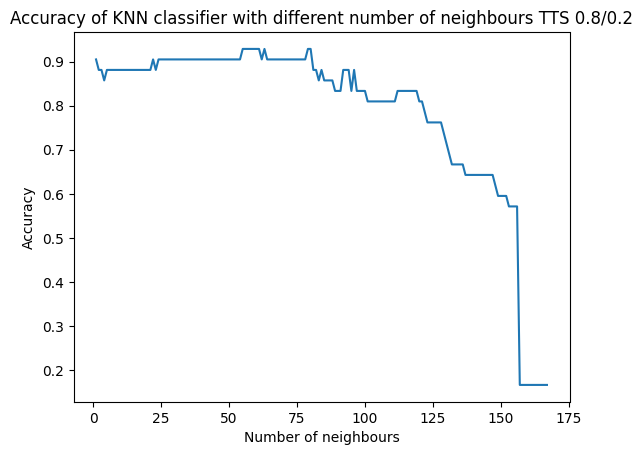

Best accuracy: 0.9285714285714286 with 55 neighbours


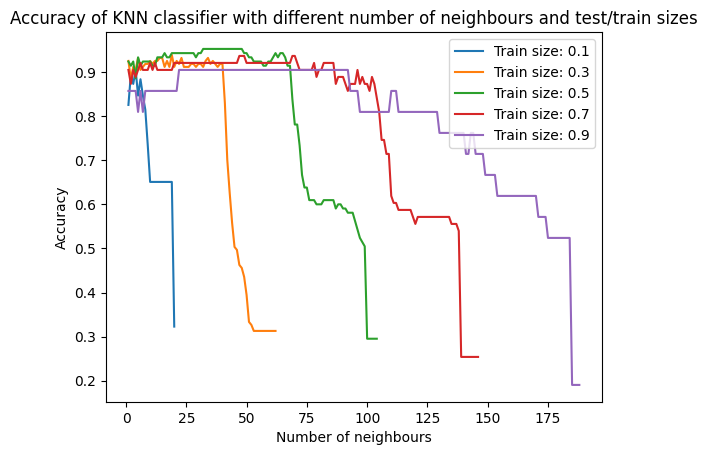

In [38]:
# Since the the training set isnt that big we decided that we can just brute force and try all possible number of neighbours
# and plot the accuracy of the classifier with different number of neighbours to see which number of neighbours gives the best accuracy

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

RANDOM_STATE_SPLIT = 1

def train_test_split_seed(train_size):
    return train_test_split(seed_df_wo_class, seed_df['Class'], train_size=train_size, random_state=RANDOM_STATE_SPLIT)

def knn_accuracy(n, x_train, x_test, y_train, y_test):
    knnc = KNeighborsClassifier(n_neighbors=n)
    knnc.fit(x_train, y_train)
    return knnc.score(x_test, y_test)

seed_df_train_X, seed_df_test_X, seed_df_train_y, seed_df_test_y = train_test_split(seed_df_wo_class, seed_df['Class'], train_size=0.8, random_state=RANDOM_STATE_SPLIT)
accuracies = [knn_accuracy(n, seed_df_train_X, seed_df_test_X, seed_df_train_y, seed_df_test_y) for n in range(1, 168)]

plt.plot(range(1, 168), accuracies)
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN classifier with different number of neighbours TTS 0.8/0.2')
plt.show()

print(f'Best accuracy: {max(accuracies)} with {accuracies.index(max(accuracies)) + 1} neighbours')

train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]
n_neighbour_ranges = [range(1,21), range(1,63), range(1,105), range(1,147), range(1,189)]

# Hypothesis: The accuracy of the KNN classifier will be more volatile with a smaller test size since the model will be more sensitive to the test data.
# Having more training data will result in bigger clusters which allows more neighbours to be used without losing accuracy.

# Result: For the second part of the problem (mainly d) we decided to make a compound plot of the accuracy of the KNN classifier with different number of neighbours and test/train sizes.
# Conclusions we can draw from this is that the higher the train size the bigger amount of neighbours we can use and still get a good accuracy. 
# The peak accuracy of each test/train size seems to be largely the same but the drop off in accuracy comes much later with a bigger train size.
# The peak accuracy for the whole test seems to be at a 50/50 train test split using n=50.

for train_size, n_range in zip(train_sizes, n_neighbour_ranges):
    x_train, x_test, y_train, y_test = train_test_split_seed(train_size)
    accuracies = [knn_accuracy(n, x_train, x_test, y_train, y_test) for n in n_range]
    plt.plot(n_range, accuracies, label=f'Train size: {train_size}')

plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN classifier with different number of neighbours and test/train sizes')
plt.legend(loc = "upper right")
plt.show()